# Results Overview
Quick reproduction of key diagnostics: RMSE time series, spectral analysis, anomaly panels, and metrics table.

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Add src to path for importing visualization utilities
geonetDir = Path().resolve().parent
sys.path.insert(0, str(geonetDir / 'src'))

from visualize import (
    computeRMSETimeSeries,
    computeLatWeights,
    zonalWavenumberSpectrum,
    computeAnomaly,
    computeCommonVminVmax,
    plotFieldOnAxis,
    loadNpy
)

## Load Saved Predictions

In [2]:
# Define paths
resultDir = Path('../results/checkpoint_epoch003_valloss0.0032')
dataDir = Path('../data/processed')

# Load prediction arrays
yTrue = loadNpy(resultDir / 'yTrue.npy')
yPred = loadNpy(resultDir / 'yPred.npy')
yPers = loadNpy(resultDir / 'yPers.npy')

# Squeeze channel dimension if present: (N, 1, H, W) -> (N, H, W)
if yTrue.ndim == 4:
    yTrue = yTrue.squeeze(1)
    yPred = yPred.squeeze(1)
    yPers = yPers.squeeze(1)

# Load lat/lon
lat = loadNpy(dataDir / 'lat.npy')
lon = loadNpy(dataDir / 'lon.npy')

# Try to load climatology
climPath = dataDir / 'climatology.npz'
if climPath.exists():
    climData = np.load(climPath)
    yClim = climData['yClim']
else:
    yClim = None

print(f"✓ yTrue shape: {yTrue.shape}")
print(f"✓ yPred shape: {yPred.shape}")
print(f"✓ yPers shape: {yPers.shape}")
print(f"✓ lat shape: {lat.shape}, lon shape: {lon.shape}")
print(f"✓ yClim shape: {yClim.shape if yClim is not None else 'None'}")

✓ yTrue shape: (43818, 12, 64)
✓ yPred shape: (43818, 12, 64)
✓ yPers shape: (43818, 12, 64)
✓ lat shape: (12,), lon shape: (64,)
✓ yClim shape: (12, 12, 64)


## Calculate RMSE Metrics

In [3]:
# Compute area-weighted RMSE time series
rmseModel = computeRMSETimeSeries(yTrue, yPred, lat)
rmsePers = computeRMSETimeSeries(yTrue, yPers, lat)

# Summary statistics
def computeMetrics(rmseArray):
    return {
        'Mean': np.mean(rmseArray),
        'Std': np.std(rmseArray),
        'Min': np.min(rmseArray),
        'Max': np.max(rmseArray),
        'Median': np.median(rmseArray),
    }

metricsModel = computeMetrics(rmseModel)
metricsPers = computeMetrics(rmsePers)

print(f"RMSE statistics computed for {rmseModel.shape[0]} samples")

RMSE statistics computed for 43818 samples


## Plot RMSE Time Series

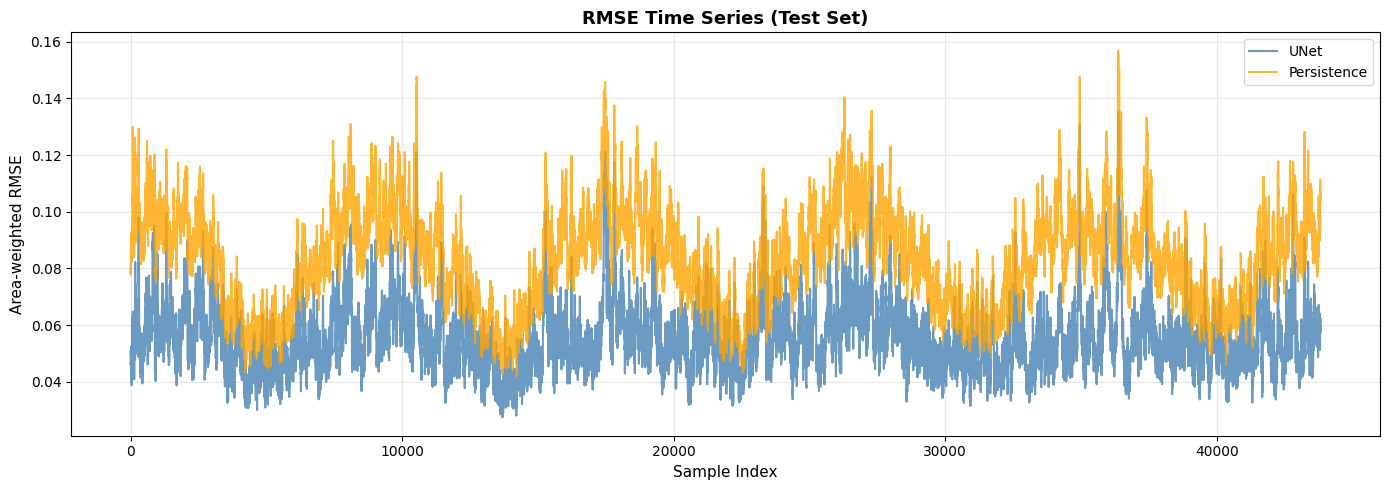


Skill improvement (UNet vs Persistence): 32.48% ± 10.41%


In [4]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(rmseModel, label='UNet', color='steelblue', linewidth=1.5, alpha=0.8)
ax.plot(rmsePers, label='Persistence', color='orange', linewidth=1.5, alpha=0.8)
ax.set_xlabel('Sample Index', fontsize=11)
ax.set_ylabel('Area-weighted RMSE', fontsize=11)
ax.set_title('RMSE Time Series (Test Set)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate skill improvement
skillGain = 100 * (rmsePers - rmseModel) / rmsePers
print(f"\nSkill improvement (UNet vs Persistence): {np.mean(skillGain):.2f}% ± {np.std(skillGain):.2f}%")

## Plot Spectral Analysis

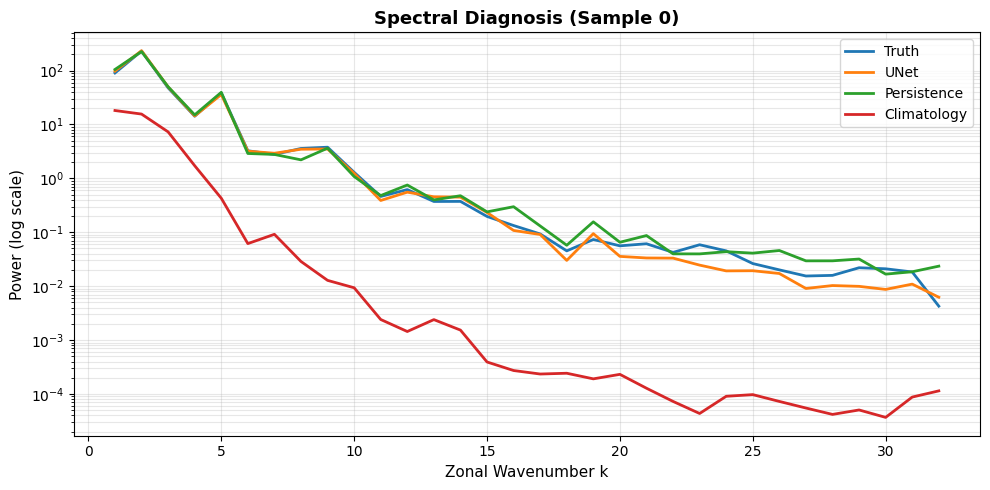

In [5]:
sampleIdx = 0

truth = yTrue[sampleIdx]
pred = yPred[sampleIdx]
pers = yPers[sampleIdx]

# Compute zonal wavenumber power spectra
kT, pT = zonalWavenumberSpectrum(truth)
kP, pP = zonalWavenumberSpectrum(pred)
kR, pR = zonalWavenumberSpectrum(pers)

fig, ax = plt.subplots(figsize=(10, 5))
ax.semilogy(kT[1:], pT[1:], label='Truth', linewidth=2)
ax.semilogy(kP[1:], pP[1:], label='UNet', linewidth=2)
ax.semilogy(kR[1:], pR[1:], label='Persistence', linewidth=2)
if yClim is not None:
    climAvg = np.mean(yClim, axis=0)
    kC, pC = zonalWavenumberSpectrum(climAvg)
    ax.semilogy(kC[1:], pC[1:], label='Climatology', linewidth=2)
ax.set_xlabel('Zonal Wavenumber k', fontsize=11)
ax.set_ylabel('Power (log scale)', fontsize=11)
ax.set_title(f'Spectral Diagnosis (Sample {sampleIdx})', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

## Plot Anomaly Panels

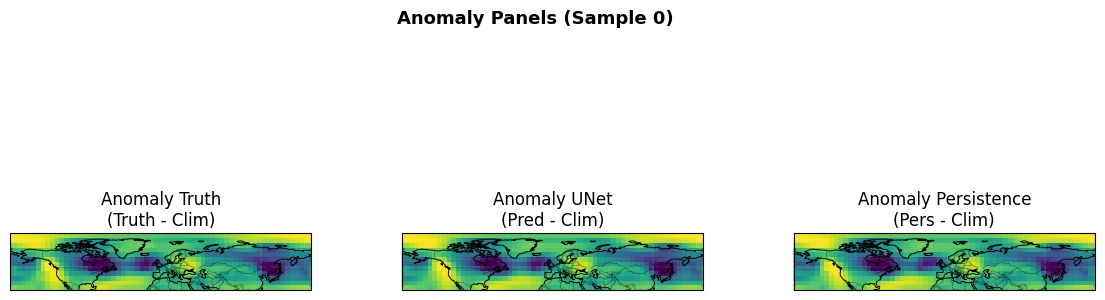

In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Use average climatology for anomaly
if yClim is not None:
    climAvg = np.mean(yClim, axis=0)  # (H, W)
    truthA = computeAnomaly(yTrue, climAvg)[sampleIdx]
    predA = computeAnomaly(yPred, climAvg)[sampleIdx]
    persA = computeAnomaly(yPers, climAvg)[sampleIdx]
    
    vmin, vmax = computeCommonVminVmax([truthA, predA, persA])
    
    fig = plt.figure(figsize=(14, 5))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1], wspace=0.3)
    
    axs = [
        fig.add_subplot(gs[0], projection=ccrs.PlateCarree()),
        fig.add_subplot(gs[1], projection=ccrs.PlateCarree()),
        fig.add_subplot(gs[2], projection=ccrs.PlateCarree()),
    ]
    
    plotFieldOnAxis(axs[0], truthA, lat, lon, 'Anomaly Truth\n(Truth - Clim)', vmin, vmax)
    plotFieldOnAxis(axs[1], predA, lat, lon, 'Anomaly UNet\n(Pred - Clim)', vmin, vmax)
    plotFieldOnAxis(axs[2], persA, lat, lon, 'Anomaly Persistence\n(Pers - Clim)', vmin, vmax)
    
    fig.suptitle(f'Anomaly Panels (Sample {sampleIdx})', fontsize=13, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
else:
    print("⚠ Climatology not available; skipping anomaly panels")

## Display Metrics Table

In [7]:
# Create summary metrics table
metricsData = {
    'Metric': ['Mean', 'Std Dev', 'Min', 'Max', 'Median'],
    'UNet RMSE': [
        f"{metricsModel['Mean']:.4f}",
        f"{metricsModel['Std']:.4f}",
        f"{metricsModel['Min']:.4f}",
        f"{metricsModel['Max']:.4f}",
        f"{metricsModel['Median']:.4f}",
    ],
    'Persistence RMSE': [
        f"{metricsPers['Mean']:.4f}",
        f"{metricsPers['Std']:.4f}",
        f"{metricsPers['Min']:.4f}",
        f"{metricsPers['Max']:.4f}",
        f"{metricsPers['Median']:.4f}",
    ],
    'Skill Gain (%)': [
        f"{100 * (metricsPers['Mean'] - metricsModel['Mean']) / metricsPers['Mean']:.2f}",
        '-',
        '-',
        '-',
        f"{100 * (metricsPers['Median'] - metricsModel['Median']) / metricsPers['Median']:.2f}",
    ]
}

dfMetrics = pd.DataFrame(metricsData)
print("\n" + "="*70)
print("PERFORMANCE METRICS SUMMARY")
print("="*70)
print(dfMetrics.to_string(index=False))
print("="*70)


PERFORMANCE METRICS SUMMARY
 Metric UNet RMSE Persistence RMSE Skill Gain (%)
   Mean    0.0553           0.0830          33.37
Std Dev    0.0118           0.0172              -
    Min    0.0274           0.0418              -
    Max    0.1355           0.1568              -
 Median    0.0536           0.0834          35.71
